In [1]:
import MeCab
import pandas as pd
import re
import itertools
from content_clustering.src.vectrizer import ContentVectorizer
import math

# ユーザー辞書を設定
m_t = MeCab.Tagger('-d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd -u test/fragrance_user_dic.dic')
#print(m_t)

# メタ付与する文章を読み込み
article_df = pd.read_table('data/perfume_sentence.tsv')

colname = ['surface', 'pos1', 'pos2', 'empty1', 'empty2', 'empty3', 'empty4', 'nomarization', 'category1', 'empty5', 'empty6', 'empty7', 'empty8', 'empty9', 'pos3', 'empty10', 'sign']

In [2]:
# 辞書から特定のカテゴリーに属するワードを抽出する
feature = []
wl_ = []

for i, sentence in enumerate(article_df['description']):
    parsed_s = m_t.parse(sentence).replace('\t',',').split('\n')
    parsed_results = pd.Series(parsed_s).str.split(',').tolist()
    df_raw = pd.DataFrame(parsed_results, columns = colname)
    # 'category1'に「香り」か「印象」属性が登録されている単語をDataFarameに登録
    f_df = df_raw[(df_raw['category1'] == '香り') | (df_raw['category1'] =='印象')]

    # 単語と香りor印象属性を抽出する
    f_m = []
    attr_dic = {}
    for s,c in zip(f_df['surface'],f_df['category1']):
        attr_dic = {'word':s,'category':c}
        wl_.append(s)
        f_m.append(attr_dic)
    feature.append(f_m)

In [11]:

import random

word_class = set(wl_)
meta_parts_pairs = []
for pair in itertools.combinations(word_class, 2):
    meta_parts_pairs.append(pair)

rand_score = []
for i in range(len(meta_parts_pairs)):
    rand_score.append(random.uniform(1, 0))
    
target_df = pd.DataFrame(meta_parts_pairs)
target_df['2']=rand_score

#target_df_dummy = pd.DataFrame([['rose', 'cute', 0.124353], ['lemon', 'herb', 0.0098163], ['beautifle', 'elegance', 0.000384627]])

In [ ]:
# 単語ベクトルの作成

In [ ]:
# クラスタリング

In [ ]:
# クラスタリング結果

In [ ]:
# クラスタごとのネットワークを作成

In [ ]:
# ネットワーク可視化

In [19]:
import networkx as nx
from networkx.drawing.nx_agraph import write_dot
import matplotlib.pyplot as plt
import japanize_matplotlib

def to_min(value, min = 0.1):
    if value > min:
        return value
    return min

def network(
    values:list, 
    size = 100,
    node_v = 0.1,
    edge_v = 0.002,
):

    plt.figure(figsize=(15, 15))

    #新規グラフを作成
    #G = nx.MultiDiGraph()
    G = nx.DiGraph()

    G.add_weighted_edges_from(values)
    node_size = []    
    color_map = []
    for node in G:
        if str(node).startswith("to_ad_"):
            color_map.append('red')
        elif str(node).startswith("to_article_"):
            color_map.append('yellow')
        elif str(node).startswith("to_"):
            color_map.append('red')            
        else: 
            color_map.append('green')
            
        
        node_size.append(size)
           
    pos = nx.spring_layout(G, k=100)
    #pos = nx.spiral_layout(G)    
    #top = nx.bipartite.sets(G)[0]
    #pos = nx.bipartite_layout(G, top)    
    
    #pos = nx.shell_layout(G)
    bbox = dict(color='white', alpha=0.5, edgecolor=None)
    edge_labels = {(i, j): w['weight'] for i, j, w in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, alpha=0.5, bbox=bbox, edge_labels=edge_labels)
    
    nx.draw(
        G, 
        pos, 
        node_color=color_map, 
        with_labels=True, 
        alpha=0.7,
        width=[to_min(w['weight'] * edge_v) for i, j, w in G.edges(data=True)],
        node_size=node_size, 
        font_family='IPAexGothic'
    )
    
    #write_dot(G,'graph.dot')
    
    #nx.draw_networkx(G, pos, node_color=color_map, with_labels=True, node_size=node_size, alpha=0.5, font_family='IPAexGothic')

    # 表示
    plt.axis("off")
    plt.show()

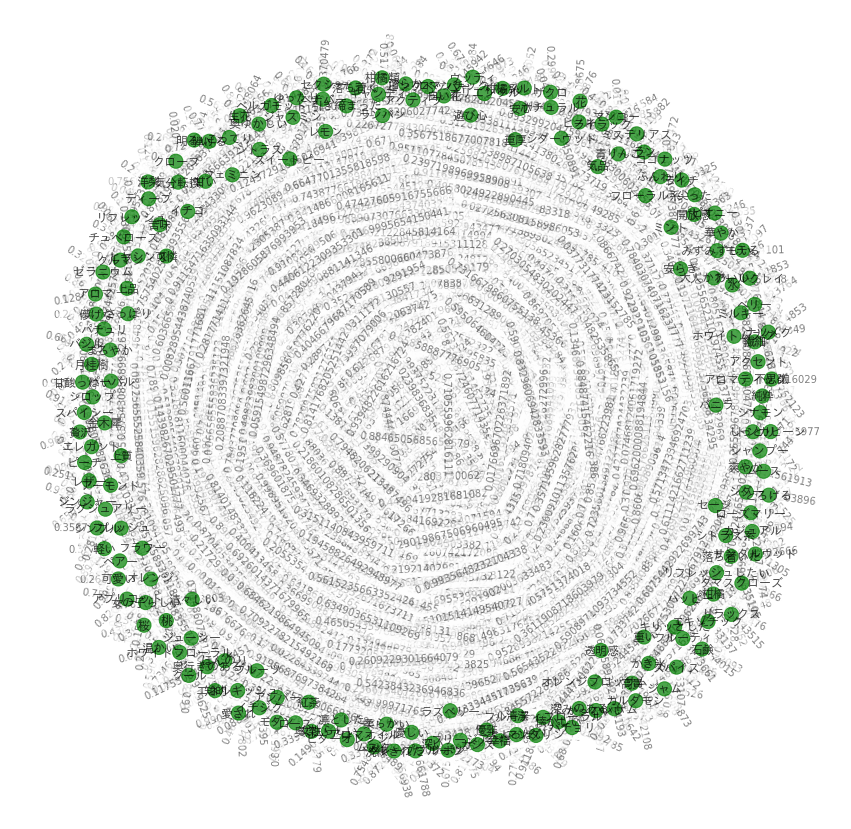

In [21]:
network(target_df.values.tolist(), 200, 0.005)

In [14]:
! 

In [148]:
!fc-match --sort :lang=ja

fonts-japanese-gothic.ttf: "Takao Pゴシック" "Regular"
DejaVuSans.ttf: "DejaVu Sans" "Book"
DejaVuSans-Bold.ttf: "DejaVu Sans" "Bold"
DejaVuSansMono.ttf: "DejaVu Sans Mono" "Book"
DejaVuSerif.ttf: "DejaVu Serif" "Book"
DejaVuSansMono-Bold.ttf: "DejaVu Sans Mono" "Bold"
DejaVuSerif-Bold.ttf: "DejaVu Serif" "Bold"


In [138]:
import matplotlib as mpl
mpl.get_configdir()

'/root/.config/matplotlib'

In [139]:
rm fontlist-v300.json

rm: 'fontlist-v300.json' を削除できません: そのようなファイルやディレクトリはありません


In [140]:
!ls /root/.config/matplotlib

In [143]:
!apt-get install fonts-takao-gothic

パッケージリストを読み込んでいます... 完了%
依存関係ツリーを作成しています                
状態情報を読み取っています... 完了
以下のパッケージが新たにインストールされます:
  fonts-takao-gothic
アップグレード: 0 個、新規インストール: 1 個、削除: 0 個、保留: 2 個。
3,523 kB のアーカイブを取得する必要があります。
この操作後に追加で 12.5 MB のディスク容量が消費されます。
取得:1 http://deb.debian.org/debian buster/main amd64 fonts-takao-gothic all 00303.01-2 [3,523 kB]
3,523 kB を 0秒 で取得しました (7,760 kB/s)       
debconf: delaying package configuration, since apt-utils is not installed
以前に未選択のパッケージ fonts-takao-gothic を選択しています。
(データベースを読み込んでいます ... 現在 31165 個のファイルとディレクトリがインストールされています。)
.../fonts-takao-gothic_00303.01-2_all.deb を展開する準備をしています ...
fonts-takao-gothic (00303.01-2) を展開しています...
fonts-takao-gothic (00303.01-2) を設定しています ...
update-alternatives: /usr/share/fonts/truetype/fonts-japanese-gothic.ttf (fonts-japanese-gothic.ttf) を提供するために自動モードで /usr/share/fonts/truetype/takao-gothic/TakaoPGothic.ttf を使います
fontconfig (2.13.1-2) のトリガを処理しています ...
